In [2]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
import pandas as pd
from keras.models import Model
import keras
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.layers import Dense,Activation,Flatten,MaxPool2D,Conv2D,Dropout
from keras.layers.normalization import BatchNormalization
import keras.backend as K
import itertools
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'


In [8]:
epochs= 2
batch_size=10

train_batches = ImageDataGenerator(preprocessing_function = keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                       train_data_dir, target_size=(224,224), batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function = keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                       validation_data_dir, target_size=(224,224), batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function = keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                       test_data_dir, target_size=(224,224), batch_size=10, shuffle=False)

Found 8000 images belonging to 2 classes.
Found 1920 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [9]:
mobile = keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [11]:
x = mobile.layers[-6].output
predictions = Dense(2, activation='softmax')(x) 
model = Model(inputs = mobile.input, outputs = predictions)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [12]:
for layer in model.layers[:-5]:
    layer.trainable=False
     

# Train the model

In [13]:
model.compile(Adam(lr=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model.fit_generator(train_batches,
                    steps_per_epoch = 800,
                    validation_data= valid_batches,
                    validation_steps = 150,
                    epochs = epochs,
                    verbose = 2)

Epoch 1/2
 - 1274s - loss: 0.1403 - accuracy: 0.9438 - val_loss: 0.0053 - val_accuracy: 0.9893
Epoch 2/2
 - 1183s - loss: 0.0927 - accuracy: 0.9639 - val_loss: 6.6833e-04 - val_accuracy: 0.9840


# Predict Cats and Dogs

In [16]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [17]:
test_batches.class_indices

{'cats': 0, 'dogs': 1}

In [18]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)
predictions

array([[9.9999321e-01, 6.7650230e-06],
       [9.9999774e-01, 2.3019525e-06],
       [9.9926704e-01, 7.3299609e-04],
       [9.9998868e-01, 1.1320203e-05],
       [9.9999261e-01, 7.3351002e-06],
       [2.3329678e-05, 9.9997663e-01],
       [9.1077993e-04, 9.9908924e-01],
       [1.4598236e-03, 9.9854016e-01],
       [2.4116507e-03, 9.9758840e-01],
       [7.3475376e-02, 9.2652458e-01]], dtype=float32)

# Confusion matrix

[[5 0]
 [0 5]]
['cats', 'dogs']


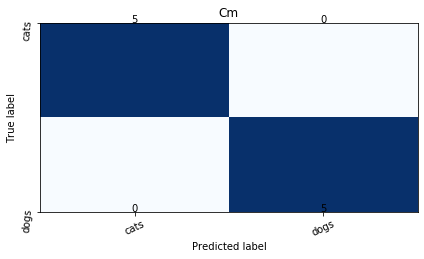

In [43]:
import os
print(confusion_matrix(test_labels, predictions.argmax(axis=1)))
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes = sorted(os.listdir(train_data_dir))
print(classes)

cmap=plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Cm')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=25)
plt.yticks(tick_marks, classes, rotation=85)

thresh = cm.max() 
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]),
           horizontalalignment="center",
           color="white" if cm[i, j] > thresh else "black"
    )

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()